In [194]:
# Import TensorFlow, Keras components, and other utilities.
# - tensorflow as tf: The core TensorFlow library.
# - tensorflow.keras : TensorFlow's high-level API for building and training models.
# - layers: Module containing standard neural network layers (Conv2D, Dense, etc.).
# - models: Module for creating models (Sequential, Functional API).
# - datasets: Module containing built-in datasets like CIFAR-100.
# - optimizers: Module containing optimization algorithms (Adam, SGD, etc.).

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets, optimizers, losses
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

# Suppress TensorFlow informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

print("Libraries imported successfully.")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

# Check for GPU availability
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU available: {gpu_devices}")
    # Optional: Configure GPU memory growth to avoid allocating all memory at once
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth configured.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("GPU not available, using CPU.")

Libraries imported successfully.
TensorFlow Version: 2.16.2
Keras Version: 3.9.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth configured.


In [196]:
# Configuration and Hyperparameters
# - BATCH_SIZE: Number of images processed in one training step.
# - LEARNING_RATE: Controls the step size during optimization.
# - NUM_EPOCHS: How many times the entire training dataset is passed through the model.
# - NUM_CLASSES: CIFAR-100 has 100 distinct image categories.
# - INPUT_SHAPE: The dimensions of each input image (Height, Width, Channels).
# - L2_LAMBDA

BATCH_SIZE = 64          # Number of images per batch
LEARNING_RATE = 0.001    # Learning rate for the optimizer
NUM_EPOCHS = 100         # Number of times to iterate over the entire dataset
NUM_CLASSES = 100        # CIFAR-100 has 100 classes
INPUT_SHAPE = (32, 32, 3) # CIFAR images are 32x32 pixels with 3 color channels (RGB)
L2_LAMBDA = 0.0002      # Define L2 regularization strength

print(f"Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Number of Classes: {NUM_CLASSES}")
print(f"  Input Shape: {INPUT_SHAPE}")

Configuration:
  Batch Size: 64
  Learning Rate: 0.001
  Number of Epochs: 100
  Number of Classes: 100
  Input Shape: (32, 32, 3)


In [198]:
# Load the dataset directly using `tf.keras.datasets.cifar100`.
# This function returns NumPy arrays for training and testing images and labels.
# - Images (`x_train`, `x_test`) are NumPy arrays of shape (num_samples, 32, 32, 3) with pixel values in [0, 255].
# - Labels (`y_train`, `y_test`) are NumPy arrays of shape (num_samples, 1) containing integer labels from 0 to 99.

print("Loading CIFAR-100 dataset...")
(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()

print("Dataset loaded successfully.")
print(f"  x_train shape: {x_train.shape}") # (50000, 32, 32, 3)
# x_train holds 50,000 images. Each of those 50,000 images is a 32x32 grid of pixels.  
# And at each of those 32x32 pixel locations, there are 3 values representing the 
# Red, Green, and Blue color components of that pixel.

print(f"  y_train shape: {y_train.shape}") # (50000, 1)
print(f"  x_test shape: {x_test.shape}")   # (10000, 32, 32, 3)
print(f"  y_test shape: {y_test.shape}")   # (10000, 1)
print(f"  Number of training samples: {x_train.shape[0]}")
print(f"  Number of test samples: {x_test.shape[0]}")
print(f"  Image data type: {x_train.dtype}") # uint8
print(f"  Label data type: {y_train.dtype}") # int64
print(f"  Min/Max pixel values: {x_train.min()}/{x_train.max()}") # 0/255

# # Print the first 2 rows of x_train (image data)
# print("\nFirst 2 rows of x_train (image data):")
# print(x_train[:2])  # Print the first 2 image arrays.

# # Print the first 2 rows of y_train (labels)
# print("\nFirst 2 rows of y_train (labels):")
# print(y_train[:2])

# # Print the first 2 rows of x_test (image data)
# print("\nFirst 5 rows of x_test (image data):")
# print(x_test[:2]) # Print the first 2 image arrays.

# # Print the first 2 rows of y_test (labels)
# print("\nFirst 2 rows of y_test (labels):")
# print(y_test[:2])

Loading CIFAR-100 dataset...
Dataset loaded successfully.
  x_train shape: (50000, 32, 32, 3)
  y_train shape: (50000, 1)
  x_test shape: (10000, 32, 32, 3)
  y_test shape: (10000, 1)
  Number of training samples: 50000
  Number of test samples: 10000
  Image data type: uint8
  Label data type: int64
  Min/Max pixel values: 0/255


In [199]:
# Prepare the data for training:
# - Convert Image Type: Change image data type from `uint8` to `float32` for calculations.
# - Normalize Pixels: Scale pixel values from the range [0, 255] to [0, 1]. This helps stabilize training. Alternatively, you could scale to [-1, 1] by dividing by 127.5 and subtracting 1.
# - Labels: The labels are already integers (0-99), which is the format expected by `SparseCategoricalCrossentropy` loss. No changes needed for `y_train`, `y_test`.

# Convert image data types to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize pixel values to the range [0, 1]
x_train /= 255.0
x_test /= 255.0

print(f"  x_train data type after conversion: {x_train.dtype}") # float32
print(f"  Min/Max pixel values after normalization: {x_train.min():.1f}/{x_train.max():.1f}") # 0.0/1.0

# Labels y_train and y_test remain as integer arrays of shape (N, 1)
print(f"  y_train shape remains: {y_train.shape}")

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=INPUT_SHAPE),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# Apply augmentation ONLY to the training data
# Apply augmentation within the tf.data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train))\
                             .batch(BATCH_SIZE)\
                             .map(lambda x, y: (data_augmentation(x, training=True), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)\
                             .prefetch(tf.data.AUTOTUNE) # Add prefetching

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)\
                           .prefetch(tf.data.AUTOTUNE) # Add prefetching

  x_train data type after conversion: float32
  Min/Max pixel values after normalization: 0.0/1.0
  y_train shape remains: (50000, 1)


In [202]:
# Building the CNN using the `keras.Sequential` model, stacking layers linearly.
# - input_shape: Specified in the first layer.
# - layers.Conv2D: 2D convolution layer.
# - layers.MaxPooling2D: Max pooling layer.
# - layers.Flatten: Converts 3D features to 1D vector.
# - layers.Dense: Fully connected layer.
# - layers.Dropout: Applies dropout regularization.
# - Final Dense Layer: Has `NUM_CLASSES` units and activation='softmax'. This makes the model output probabilities for each class.

print(f"Defining the Keras Sequential model (with Batch Norm, L2, Softmax output)...")

model = models.Sequential([
    # Block 1: Two Conv2D layers
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA), input_shape=INPUT_SHAPE),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: Two Conv2D layers
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 3: Two Conv2D layers
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 4: Two Conv2D layers (new)
    layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 5: Two Conv2D layers (new)
    layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Flatten and Dense Layers
    layers.Flatten(),
    layers.Dense(1024, kernel_regularizer=l2(L2_LAMBDA)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=l2(L2_LAMBDA)),  # New dense layer
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

print("Model defined successfully with Batch Norm, L2, and Softmax output.")

# Print a summary of the model's layers and parameters
model.summary()

Defining the Keras Sequential model (with Batch Norm, L2, Softmax output)...
Model defined successfully with Batch Norm, L2, and Softmax output.


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 8, 8, 128)      │             

 Total params: 5,827,716 (22.23 MB)

 Trainable params: 5,820,676 (22.20 MB)

 Non-trainable params: 7,040 (27.50 KB)

In [204]:
# Configuring the model for training.
# - optimizer: Adam optimizer.
# - loss: The loss function.
# - SparseCategoricalCrossentropy: Used for multi-class classification with integer labels (0-99).
# - metrics: [accuracy] to monitor classification accuracy.

# initial_learning_rate = LEARNING_RATE 
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps= (len(x_train) // BATCH_SIZE) * 5, # Decay every 5 epochs approx
#     decay_rate=0.9, # Decay factor
#     staircase=True)

# Applying the schedule in the optimizer
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

# Define the loss function suitable for probability outputs from Softmax
# Use SparseCategoricalCrossentropy because labels are integers (0-99)
loss_fn = losses.SparseCategoricalCrossentropy()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Reduce learning rate if val_loss doesn't improve for 'patience' epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # Reduce LR by a factor of 5 (1 * 0.2 = 0.2)
                              patience=3,  # Reduce LR if no improvement for 3 epochs
                              min_lr=1e-6, # Minimum learning rate
                              verbose=1)   # Print a message when LR is reduced

print("Model compiled successfully")

Model compiled successfully


In [ ]:
# Training the model using the `model.fit()` method.

print(f"\nStarting training for {NUM_EPOCHS} epochs...")

history = model.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset, # Evaluate on test set after each epoch
    callbacks=[early_stopping, reduce_lr]
)
print("Training finished!")


Starting training for 100 epochs...
Epoch 1/100
237/782 ━━━━━━━━━━━━━━━━━━━━ 2:14 246ms/step - accuracy: 0.0151 - loss: 5.5920


Evaluating the model on the test dataset...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5336 - loss: 1.9895

Test Loss: 1.9773
Test Accuracy: 53.22%

Plotting training history...


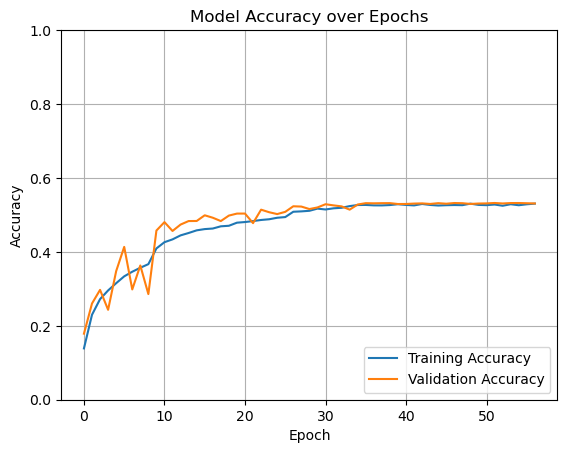

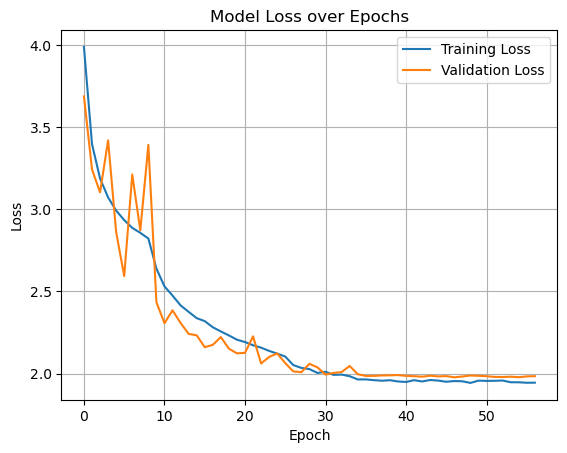

In [189]:
# Evaluating the trained model's performance on the test dataset using `model.evaluate()`.
# - Pass the test data (`test_dataset`).
# - It returns the final loss and metric values (e.g., accuracy) calculated on the test set.
# Evaluate the model

print("\nEvaluating the model on the test dataset...")

loss, accuracy = model.evaluate(
    test_dataset, 
    verbose=1
)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

print("\nPlotting training history...")

plt.plot(history.history['accuracy'], label='Training Accuracy') 
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy') 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs') 
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss') 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs') 
plt.legend(loc='upper right')
plt.grid(True) 
plt.show()